In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.types import *
from pyspark.ml.feature import Normalizer, StandardScaler
# import random
# import logging
import time
import json
from datetime import datetime
from pymongo import MongoClient



schema = StructType([ \
    StructField("RGIID",StringType(),True), 
    StructField("Time",StringType(),True), 
    StructField("Area",FloatType(),True), 
    StructField("dh",FloatType(),True), 
    StructField("err_dh",FloatType(),True),                  
  ])

client = MongoClient('localhost', 27017)
db = client.ICS5114

iceland_collection = db.glacial_iceland_collection
europe_collection = db.glacial_europe_collection

def collection_getter(cursor):
    temp_collection = []
    for document in cursor:  
        try:
            temp_collection.append((document["rgiid"],document["time"],document["area"],document["dh"],document["err_dh"]))
        except Exception as e: print()
    return temp_collection

def initial_df(collection, time_format):
    df = spark.createDataFrame(data=collection,schema=schema)
    if(time_format == "/"):
        time_style = "dd/MM/yyyy"
    else:
        time_style = "yyyy-MM-dd"
    df = df.withColumn("Time_formatted", f.to_date(f.col("Time"), time_style))     
    df = df.sort("RGIID","Time_formatted")
    return df

temp_iceland_collection = collection_getter(iceland_collection.find({}))
temp_europe_collection = collection_getter(europe_collection.find({}))

iceland_df = initial_df(temp_iceland_collection, "/")
europe_df = initial_df(temp_europe_collection, "-")

# iceland_df

print("Iceland dataframe")
iceland_df.printSchema()
iceland_df.show()

print("Europe dataframe")
europe_df.printSchema()
europe_df.show()

Iceland dataframe
root
 |-- RGIID: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Area: float (nullable = true)
 |-- dh: float (nullable = true)
 |-- err_dh: float (nullable = true)
 |-- Time_formatted: date (nullable = true)

+--------------+----------+---------+------+------+--------------+
|         RGIID|      Time|     Area|    dh|err_dh|Time_formatted|
+--------------+----------+---------+------+------+--------------+
|RGI60-06.00001|01/01/2000|4903000.0|   0.0| 2.342|    2000-01-01|
|RGI60-06.00001|31/01/2000|4903000.0|-0.064|  2.32|    2000-01-31|
|RGI60-06.00001|02/03/2000|4903000.0|-0.143| 2.298|    2000-03-02|
|RGI60-06.00001|01/04/2000|4903000.0|-0.247| 2.275|    2000-04-01|
|RGI60-06.00001|02/05/2000|4903000.0|-0.412| 2.251|    2000-05-02|
|RGI60-06.00001|01/06/2000|4903000.0|-0.656| 2.227|    2000-06-01|
|RGI60-06.00001|02/07/2000|4903000.0|-0.931| 2.205|    2000-07-02|
|RGI60-06.00001|01/08/2000|4903000.0|-1.152| 2.196|    2000-08-01|
|RGI60-06.00001|0

In [2]:
print("Iceland dataframe")
iceland_df.describe().show()

print("Europe dataframe")
europe_df.describe().show()


Iceland dataframe
+-------+--------------+----------+--------------------+-----------------+-----------------+
|summary|         RGIID|      Time|                Area|               dh|           err_dh|
+-------+--------------+----------+--------------------+-----------------+-----------------+
|  count|        136887|    136887|              136887|           136887|           136887|
|   mean|          null|      null|1.9471436196570896E7|-4.64186489664232|2.572899574157931|
| stddev|          null|      null|1.1690602907993433E8|7.298624478050673|0.951973502345685|
|    min|RGI60-06.00001|01/01/2000|             44000.0|          -91.909|            0.413|
|    max|RGI60-06.00568|31/12/2016|        1.56121805E9|           34.833|            12.39|
+-------+--------------+----------+--------------------+-----------------+-----------------+

Europe dataframe
+-------+--------------+----------+-----------------+------------------+-----------------+
|summary|         RGIID|      Time| 

In [3]:
# count null values
import pyspark.sql.functions as f
print("Number of Nulls per dataframe \n")
print("Iceland dataframe")
nulls = iceland_df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in iceland_df.columns])
nulls.show()
print("Europe dataframe")
nulls = europe_df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in europe_df.columns])
nulls.show()

Number of Nulls per dataframe 

Iceland dataframe
+-----+----+----+---+------+--------------+
|RGIID|Time|Area| dh|err_dh|Time_formatted|
+-----+----+----+---+------+--------------+
|    0|   0|   0|  0|     0|             0|
+-----+----+----+---+------+--------------+

Europe dataframe
+-----+----+----+------+------+--------------+
|RGIID|Time|Area|    dh|err_dh|Time_formatted|
+-----+----+----+------+------+--------------+
|    0|   0|   0|124115|123874|             0|
+-----+----+----+------+------+--------------+



In [34]:
iceland_df.count()

136887

In [4]:
# pearson correlation
from pyspark.sql.functions import * 
print("Iceland - Pearrson correlation between Area and Glacier elavation change")
print(iceland_df.stat.corr("Area", "dh"))
print("Europe - Pearrson correlation between Area and Glacier elavation change")
print(europe_df.stat.corr("Area", "dh"))


Iceland - Pearrson correlation between Area and Glacier elavation change
-0.1457903292574538
Europe - Pearrson correlation between Area and Glacier elavation change
-0.1049618624089156


In [5]:
iceland_df.columns

['RGIID', 'Time', 'Area', 'dh', 'err_dh', 'Time_formatted']

In [6]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [7]:
print("Iceland - Number of Distinct Glaciers:", iceland_df.select('RGIID').distinct().count())
print("Europe - Number of Distinct Glaciers:", europe_df.select('RGIID').distinct().count())


Iceland - Number of Distinct Glaciers: 568
Europe - Number of Distinct Glaciers: 3927


In [8]:
from pyspark.sql.window import Window

def window_function(df):
    window_days = 3
    window = (
        Window
        .partitionBy(f.col("RGIID"))
        .orderBy(f.col("Time_formatted").cast("timestamp").cast("long"))
        .rowsBetween(-window_days, Window.currentRow-1)
    )

    new_all_data = (df
        .withColumn("sum",f.sum(f.col("dh")).over(window))
        .withColumn("mean",f.avg(f.col("dh")).over(window))
        .withColumn("min",f.min(f.col("dh")).over(window))
        .withColumn("max",f.max(f.col("dh")).over(window)))
    #     .withColumn("stddev",f.stddev(f.col("dh")).over(window)))

    w = (
        Window
        .partitionBy(f.col("RGIID"))
        .orderBy(f.col("Time_formatted").cast("timestamp").cast("long"))
    ) 

    # creating difference between last known dh and first known dh value in rolling window.
    df_lagger = new_all_data.withColumn('diff', f.lag(f.col("dh"),1).over(w) - f.lag(f.col("dh"),window_days).over(w))
    # df_lagger.show()
    df_lagger_update = df_lagger.withColumn("Trend", f.signum(f.col("diff")))
    #
    new_df_lagger = df_lagger_update.withColumn('next_dh', f.lag(f.col("dh"),-1).over(w))
    # now including sign 
    return new_df_lagger

iceland_df_trend = window_function(iceland_df)
europe_df_trend = window_function(europe_df)

print("Iceland dataframe with Trends")
iceland_df_trend.show()
print("Europe dataframe with Trends")
europe_df_trend.show()


Iceland dataframe with Trends
+--------------+----------+---------+------+------+--------------+--------------------+--------------------+------+------+------------+-----+-------+
|         RGIID|      Time|     Area|    dh|err_dh|Time_formatted|                 sum|                mean|   min|   max|        diff|Trend|next_dh|
+--------------+----------+---------+------+------+--------------+--------------------+--------------------+------+------+------------+-----+-------+
|RGI60-06.00001|01/01/2000|4903000.0|   0.0| 2.342|    2000-01-01|                null|                null|  null|  null|        null| null| -0.064|
|RGI60-06.00001|31/01/2000|4903000.0|-0.064|  2.32|    2000-01-31|                 0.0|                 0.0|   0.0|   0.0|        null| null| -0.143|
|RGI60-06.00001|02/03/2000|4903000.0|-0.143| 2.298|    2000-03-02|-0.06400000303983688|-0.03200000151991844|-0.064|   0.0|        null| null| -0.247|
|RGI60-06.00001|01/04/2000|4903000.0|-0.247| 2.275|    2000-04-01| -0.

In [35]:
iceland_df_trend.count()

136887

In [36]:
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

def feature_vector_adder(df):
    
    formatted_df = df.withColumn('Year', f.year(f.col('Time_formatted')))
    # vec_assembler = VectorAssembler(inputCols = ["Area", "dh","sum", "min", "max", "mean"], outputCol='features')
    vec_assembler_1 = VectorAssembler(inputCols = ["Area","mean", "diff"], outputCol='features')
    output_df = vec_assembler_1.transform(formatted_df.dropna()) 
    output_df.printSchema()
    output_df.show()
    return output_df

print("Iceland df - with features")
iceland_df_trend_features = feature_vector_adder(iceland_df_trend)

print("Europe df - with features")
europe_df_trend_features = feature_vector_adder(europe_df_trend)

Iceland df - with features
root
 |-- RGIID: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Area: float (nullable = true)
 |-- dh: float (nullable = true)
 |-- err_dh: float (nullable = true)
 |-- Time_formatted: date (nullable = true)
 |-- sum: double (nullable = true)
 |-- mean: double (nullable = true)
 |-- min: float (nullable = true)
 |-- max: float (nullable = true)
 |-- diff: float (nullable = true)
 |-- Trend: double (nullable = true)
 |-- next_dh: float (nullable = true)
 |-- Year: integer (nullable = true)
 |-- features: vector (nullable = true)

+--------------+----------+---------+------+------+--------------+--------------------+--------------------+------+------+------------+-----+-------+----+--------------------+
|         RGIID|      Time|     Area|    dh|err_dh|Time_formatted|                 sum|                mean|   min|   max|        diff|Trend|next_dh|Year|            features|
+--------------+----------+---------+------+------+--------------+-

In [37]:
def feature_df_prep(df):
    final_data = df.select('Year','features','Trend')
    final_data = final_data.withColumn("Trend",f.when(f.col("Trend") <= 0, 0).otherwise(f.col("Trend")))
    final_data.show()
    return final_data

print("Iceland features df")
iceland_feat_df = feature_df_prep(iceland_df_trend_features)
print("Europe features df")
europe_feat_df = feature_df_prep(europe_df_trend_features)


Iceland features df
+----+--------------------+-----+
|Year|            features|Trend|
+----+--------------------+-----+
|2000|[4903000.0,-0.069...|  0.0|
|2000|[4903000.0,-0.151...|  0.0|
|2000|[4903000.0,-0.267...|  0.0|
|2000|[4903000.0,-0.438...|  0.0|
|2000|[4903000.0,-0.666...|  0.0|
|2000|[4903000.0,-0.912...|  0.0|
|2000|[4903000.0,-1.117...|  0.0|
|2000|[4903000.0,-1.238...|  0.0|
|2000|[4903000.0,-1.279...|  0.0|
|2000|[4903000.0,-1.279...|  1.0|
|2001|[4903000.0,-1.279...|  0.0|
|2001|[4903000.0,-1.304...|  0.0|
|2001|[4903000.0,-1.355...|  0.0|
|2001|[4903000.0,-1.428...|  0.0|
|2001|[4903000.0,-1.535...|  0.0|
|2001|[4903000.0,-1.695...|  0.0|
|2001|[4903000.0,-1.912...|  0.0|
|2001|[4903000.0,-2.147...|  0.0|
|2001|[4903000.0,-2.341...|  0.0|
|2001|[4903000.0,-2.450...|  0.0|
+----+--------------------+-----+
only showing top 20 rows

Europe features df
+----+--------------------+-----+
|Year|            features|Trend|
+----+--------------------+-----+
|2000|[908000.0,0

In [38]:
# iceland_df_trend.show()
iceland_df_trend_features.orderBy(f.col('Year').desc()).show()

+--------------+----------+--------+------+------+--------------+--------------------+--------------------+------+------+-------------+-----+-------+----+--------------------+
|         RGIID|      Time|    Area|    dh|err_dh|Time_formatted|                 sum|                mean|   min|   max|         diff|Trend|next_dh|Year|            features|
+--------------+----------+--------+------+------+--------------+--------------------+--------------------+------+------+-------------+-----+-------+----+--------------------+
|RGI60-06.00005|02/04/2019|978000.0|  0.46| 2.188|    2019-04-02| 0.38099998608231544|  0.1269999953607718|-0.038| 0.295|   0.33299997|  1.0|  0.554|2019|[978000.0,0.12699...|
|RGI60-06.00006|02/12/2019|912000.0|-6.923| 2.459|    2019-12-02|  -21.84600019454956| -7.2820000648498535|-7.419|-7.112|   0.30700016|  1.0| -6.779|2019|[912000.0,-7.2820...|
|RGI60-06.00005|03/05/2019|978000.0| 0.554| 2.163|    2019-05-03|  0.8789999932050705|  0.2929999977350235| 0.124|  0.46

In [40]:
from pyspark.sql import Row

def train_test_df_split(df):
    train_df = df.where((f.col('Year') != 2019) & (col('Trend').isNotNull()))
    test_df = df.where((f.col('Year') == 2019) & (col('Trend').isNotNull()))
#     test_df.show()
    return train_df, test_df

iceland_train_df, iceland_test_df = train_test_df_split(iceland_feat_df)
europe_train_df, europe_test_df = train_test_df_split(europe_feat_df)


print("Training data - Iceland")
iceland_train_df.show()
print("Testing data - Iceland")
iceland_test_df.show()
print("----------------------------")
print("Training data - Europe")
europe_train_df.show()
print("Testing data - Europe")
europe_test_df.show()

Training data - Iceland
+----+--------------------+-----+
|Year|            features|Trend|
+----+--------------------+-----+
|2000|[4903000.0,-0.069...|  0.0|
|2000|[4903000.0,-0.151...|  0.0|
|2000|[4903000.0,-0.267...|  0.0|
|2000|[4903000.0,-0.438...|  0.0|
|2000|[4903000.0,-0.666...|  0.0|
|2000|[4903000.0,-0.912...|  0.0|
|2000|[4903000.0,-1.117...|  0.0|
|2000|[4903000.0,-1.238...|  0.0|
|2000|[4903000.0,-1.279...|  0.0|
|2000|[4903000.0,-1.279...|  1.0|
|2001|[4903000.0,-1.279...|  0.0|
|2001|[4903000.0,-1.304...|  0.0|
|2001|[4903000.0,-1.355...|  0.0|
|2001|[4903000.0,-1.428...|  0.0|
|2001|[4903000.0,-1.535...|  0.0|
|2001|[4903000.0,-1.695...|  0.0|
|2001|[4903000.0,-1.912...|  0.0|
|2001|[4903000.0,-2.147...|  0.0|
|2001|[4903000.0,-2.341...|  0.0|
|2001|[4903000.0,-2.450...|  0.0|
+----+--------------------+-----+
only showing top 20 rows

Testing data - Iceland
+----+--------------------+-----+
|Year|            features|Trend|
+----+--------------------+-----+
|2019|[49

In [41]:
from pyspark.ml.classification import *

def LR_prep(train_df, test_df):
    LR_model = LogisticRegression(labelCol = 'Trend')
    LR_model = LR_model.fit(train_df)
    predictions = LR_model.evaluate(test_df)
    predictions = predictions.predictions
    predictions.show()
    return predictions

print("Iceland log regression results")
iceland_lr_predictions = LR_prep(iceland_train_df, iceland_test_df)

print("Europe log regression results")
europe_lr_predictions = LR_prep(europe_train_df, europe_test_df)

Iceland log regression results


C:\spark\python\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+----+--------------------+-----+--------------------+-----------+----------+
|Year|            features|Trend|       rawPrediction|probability|prediction|
+----+--------------------+-----+--------------------+-----------+----------+
|2019|[4903000.0,-7.265...|  1.0|[-8533.3735585880...|  [0.0,1.0]|       1.0|
|2019|[4903000.0,-7.110...|  1.0|[-7561.1347058891...|  [0.0,1.0]|       1.0|
|2019|[4903000.0,-6.975...|  1.0|[-6179.5478528279...|  [0.0,1.0]|       1.0|
|2019|[4903000.0,-6.859...|  1.0|[-5463.1541712046...|  [0.0,1.0]|       1.0|
|2019|[4903000.0,-6.759...|  1.0|[-4874.7008298771...|  [0.0,1.0]|       1.0|
|2019|[4903000.0,-6.688...|  1.0|[-2776.7520726940...|  [0.0,1.0]|       1.0|
|2019|[4903000.0,-6.678...|  0.0|[1495.90400499163...|  [1.0,0.0]|       0.0|
|2019|[4903000.0,-6.743...|  0.0|[5487.11618202455...|  [1.0,0.0]|       0.0|
|2019|[4903000.0,-6.843...|  0.0|[5666.19747757479...|  [1.0,0.0]|       0.0|
|2019|[4903000.0,-6.911...|  0.0|[1802.88522318724...|  [1.0,0.0

In [42]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# evaluating predictions
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol="Trend")

print("Iceland predictions evaluation")
print(evaluator.evaluate(iceland_lr_predictions))

print("Europe predictions evaluation")
print(evaluator.evaluate(europe_lr_predictions))


Iceland predictions evaluation
1.0
Europe predictions evaluation
1.0


In [ ]:
# https://www.youtube.com/watch?v=oDTJxEl95Go  - used as guide for spark.ml library

In [43]:
from pyspark.ml.classification import LinearSVC

def SVM_prep(train_df, test_df):
    svm = LinearSVC(maxIter=10, regParam=0.1 ,labelCol = 'Trend')
    SVM_model = svm.fit(train_df)
    svm_predictions = SVM_model.evaluate(test_df)
    svm_predictions = svm_predictions.predictions
    svm_predictions.show()
    return svm_predictions

print("Iceland svm results")
iceland_svm_predictions = SVM_prep(iceland_train_df, iceland_test_df)

print("Europe svm results")
europe_svm_predictions = SVM_prep(europe_train_df, europe_test_df)

Iceland svm results
+----+--------------------+-----+--------------------+----------+
|Year|            features|Trend|       rawPrediction|prediction|
+----+--------------------+-----+--------------------+----------+
|2019|[4903000.0,-7.265...|  1.0|[-0.9479267936949...|       1.0|
|2019|[4903000.0,-7.110...|  1.0|[-0.8224113940820...|       1.0|
|2019|[4903000.0,-6.975...|  1.0|[-0.6425584143969...|       1.0|
|2019|[4903000.0,-6.859...|  1.0|[-0.5500877519468...|       1.0|
|2019|[4903000.0,-6.759...|  1.0|[-0.4742290984247...|       1.0|
|2019|[4903000.0,-6.688...|  1.0|[-0.1987728357754...|       1.0|
|2019|[4903000.0,-6.678...|  0.0|[0.36457369316561...|       0.0|
|2019|[4903000.0,-6.743...|  0.0|[0.89208709051230...|       0.0|
|2019|[4903000.0,-6.843...|  0.0|[0.91745762662263...|       0.0|
|2019|[4903000.0,-6.911...|  0.0|[0.40911738954382...|       0.0|
|2019|[4903000.0,-6.894...|  1.0|[-0.2930401417560...|       1.0|
|2019|[4903000.0,-6.789...|  1.0|[-0.8280053240900...|  

In [44]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

svm_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol="Trend")

print("Iceland svm predictions evaluation")
print(svm_evaluator.evaluate(iceland_svm_predictions))

print("Europe svm predictions evaluation")
print(svm_evaluator.evaluate(europe_svm_predictions))

Iceland svm predictions evaluation
0.9242134705150279
Europe svm predictions evaluation
0.7338380886073154


In [45]:
print("Null Counter")

print("Iceland dataframe")
nulls = iceland_df_trend.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in iceland_df_trend.columns])
nulls.show()
print("Europe dataframe")
nulls = europe_df_trend.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in europe_df_trend.columns])
nulls.show()

Null Counter
Iceland dataframe
+-----+----+----+---+------+--------------+---+----+---+---+----+-----+-------+
|RGIID|Time|Area| dh|err_dh|Time_formatted|sum|mean|min|max|diff|Trend|next_dh|
+-----+----+----+---+------+--------------+---+----+---+---+----+-----+-------+
|    0|   0|   0|  0|     0|             0|568| 568|568|568|1704| 1704|    568|
+-----+----+----+---+------+--------------+---+----+---+---+----+-----+-------+

Europe dataframe
+-----+----+----+------+------+--------------+------+------+------+------+------+------+-------+
|RGIID|Time|Area|    dh|err_dh|Time_formatted|   sum|  mean|   min|   max|  diff| Trend|next_dh|
+-----+----+----+------+------+--------------+------+------+------+------+------+------+-------+
|    0|   0|   0|124115|123874|             0|127527|127527|127527|127527|134351|134351| 127527|
+-----+----+----+------+------+--------------+------+------+------+------+------+------+-------+



In [49]:

iceland_train_df_lr, iceland_test_df_lr = train_test_df_split(iceland_df_trend_features)
europe_train_df_lr, europe_test_df_lr = train_test_df_split(europe_df_trend_features)


def lin_reg_prep(train_df, test_df):
    lm = LinearRegression(labelCol="next_dh")
    LR_model = lm.fit(train_df)

    LR_predictions_res = LR_model.evaluate(test_df)
    LR_predictions = LR_predictions_res.predictions
    LR_predictions.show()
    return LR_predictions_res


print("Iceland linear regression predictions")
iceland_lin_reg_pred = lin_reg_prep(iceland_train_df_lr, iceland_test_df_lr)

print("Europe linear regression predictions")
europe_lin_reg_pred = lin_reg_prep(europe_train_df_lr, europe_test_df_lr)




Iceland linear regression predictions
+--------------+----------+---------+------+------+--------------+-------------------+-------------------+------+------+------------+-----+-------+----+--------------------+------------------+
|         RGIID|      Time|     Area|    dh|err_dh|Time_formatted|                sum|               mean|   min|   max|        diff|Trend|next_dh|Year|            features|        prediction|
+--------------+----------+---------+------+------+--------------+-------------------+-------------------+------+------+------------+-----+-------+----+--------------------+------------------+
|RGI60-06.00001|01/01/2019|4903000.0|-6.968| 1.864|    2019-01-01|  -21.7979998588562| -7.265999952952067|-7.434|  -7.1|   0.3340001|  1.0| -6.858|2019|[4903000.0,-7.265...| -7.01004783535423|
|RGI60-06.00001|31/01/2019|4903000.0|-6.858| 1.841|    2019-01-31| -21.33199977874756| -7.110666592915853|-7.264|-6.968|       0.296|  1.0| -6.754|2019|[4903000.0,-7.110...|-6.88855971648902

In [50]:
def linear_reg_analysis_fn(LR_predictions_res):
    print("Linear Regression - Further Analysis")
    print("RMSE -> ",LR_predictions_res.rootMeanSquaredError)
    print("R2 -> ",LR_predictions_res.r2)
    print("MSE -> ",LR_predictions_res.meanSquaredError)
    print("MAE -> ",LR_predictions_res.meanAbsoluteError)
    
print("Iceland data")
linear_reg_analysis_fn(iceland_lin_reg_pred)

print("Europe data")
linear_reg_analysis_fn(europe_lin_reg_pred)

Iceland data
Linear Regression - Further Analysis
RMSE ->  0.47840693995316574
R2 ->  0.9975913040910092
MSE ->  0.22887320019535196
MAE ->  0.30181797192095616
Europe data
Linear Regression - Further Analysis
RMSE ->  0.4404615830408236
R2 ->  0.9979494733668366
MSE ->  0.19400640613482836
MAE ->  0.2583177637750606


Further Analysis

---- Iceland ----


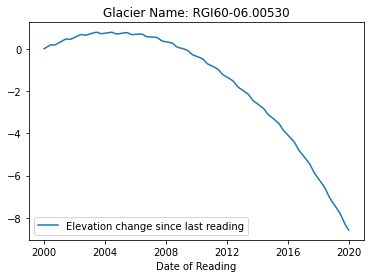

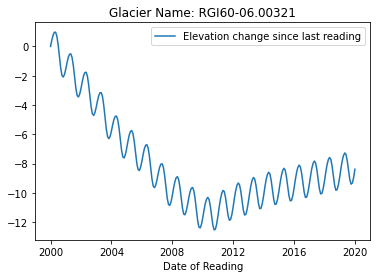

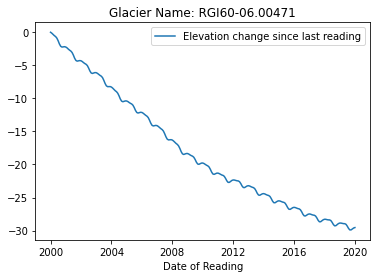

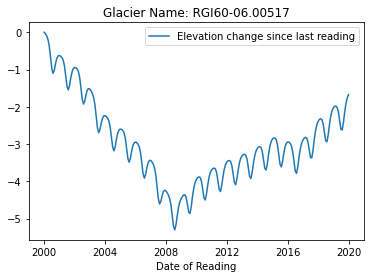

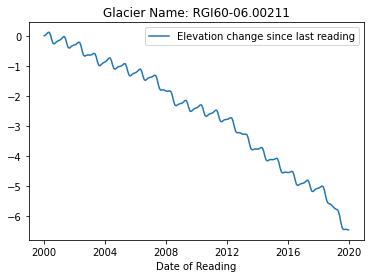

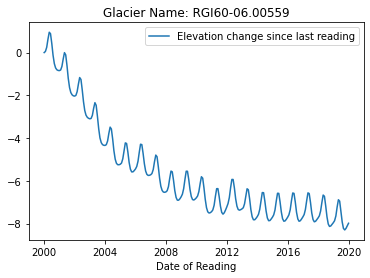

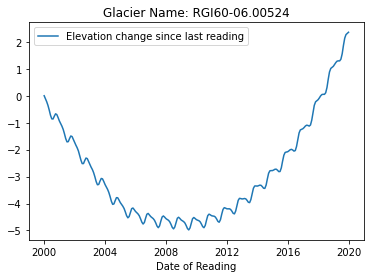

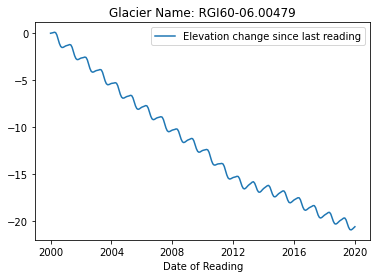

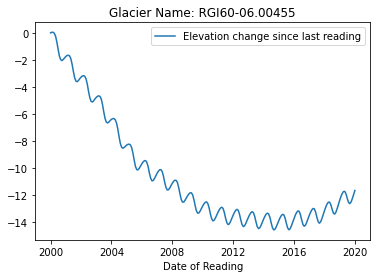

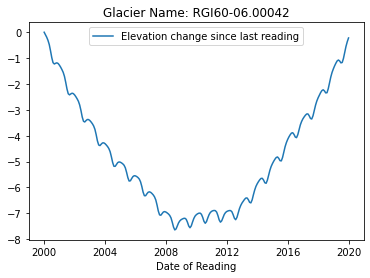

In [51]:
existing_glaciers = [row.RGIID for row in iceland_df.select('RGIID').distinct().collect()]
print("---- Iceland ----")
# as shown in cell NUMBER, creating an average of each month of each year 
# would not provide any new information since there is approximately only one measurement per month

import random
random.seed(42)
chosen_glaciers = random.sample(existing_glaciers, 10)

for glacier in chosen_glaciers:
    # plot_test = formatted_df.groupBy('Time_formatted', 'RGIID').agg(f.avg('dh').alias('avg_dh'))

    df_to_pd = (iceland_df.where(f.col('RGIID') == glacier)
                                 .select(col('dh').alias('Elevation change since last reading'),
                                         col('Time_formatted').alias('Date of Reading'))
                                 .orderBy('Date of Reading')
                                 .toPandas())

    df_to_pd.plot.line(x='Date of Reading', y='Elevation change since last reading', title = 'Glacier Name: ' + glacier)

---- Europe ----


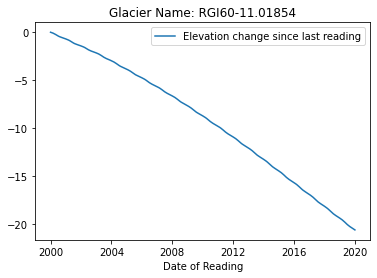

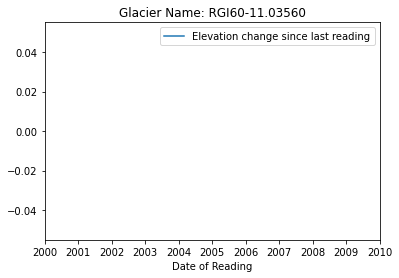

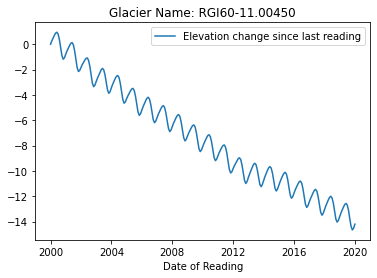

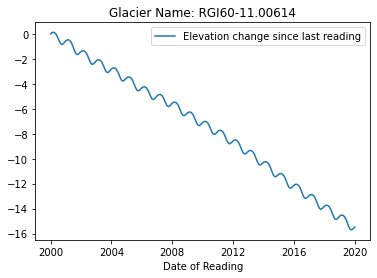

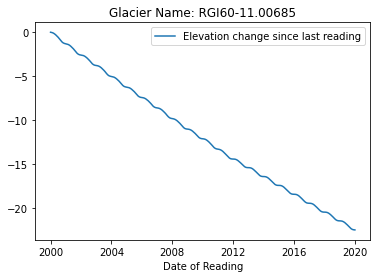

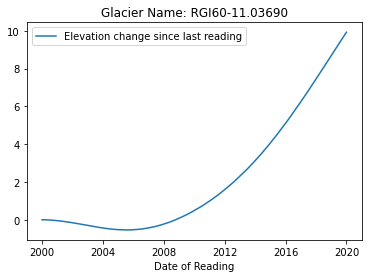

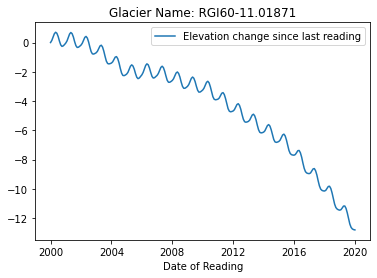

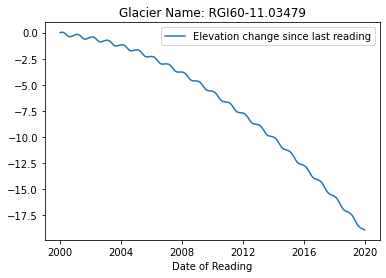

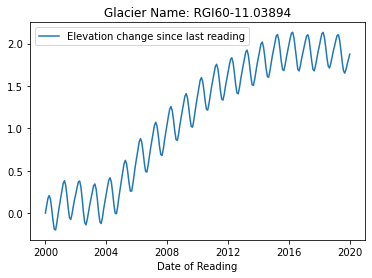

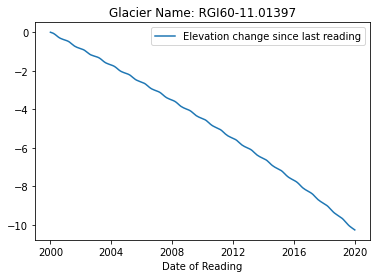

In [52]:
print("---- Europe ----")

existing_glaciers = [row.RGIID for row in europe_df.select('RGIID').distinct().collect()]

# as shown in cell NUMBER, creating an average of each month of each year 
# would not provide any new information since there is approximately only one measurement per month

import random
random.seed(42)
chosen_glaciers = random.sample(existing_glaciers, 10)

for glacier in chosen_glaciers:
    # plot_test = formatted_df.groupBy('Time_formatted', 'RGIID').agg(f.avg('dh').alias('avg_dh'))

    df_to_pd = (europe_df.where(f.col('RGIID') == glacier)
                                 .select(col('dh').alias('Elevation change since last reading'),
                                         col('Time_formatted').alias('Date of Reading'))
                                 .orderBy('Date of Reading')
                                 .toPandas())

    df_to_pd.plot.line(x='Date of Reading', y='Elevation change since last reading', title = 'Glacier Name: ' + glacier)

---- Iceland ----
+----+-------------------+----------+
|year|       total_change|total_rows|
+----+-------------------+----------+
|2000| -2292.889998081024|      7383|
|2001| -5145.070996000664|      6248|
|2002| -8906.281006328878|      6816|
|2003|-12910.972997940611|      6816|
|2004|-19072.588009116822|      7384|
|2005| -19407.32100328128|      6248|
|2006|-23688.081002329825|      6816|
|2007|-26829.902966957074|      6816|
|2008| -32864.64296666451|      7384|
|2009|-30173.563007734716|      6248|
|2010| -35666.78000405384|      6816|
|2011| -38218.70505212818|      6816|
|2012| -43515.39902734826|      7384|
|2013| -38711.79900310992|      6248|
|2014|-44076.389001333155|      6816|
|2015|  -45647.3139942158|      6816|
|2016| -51743.22401050618|      7384|
|2017| -46175.47200370685|      6248|
|2018| -51962.63803605421|      6816|
|2019|-53837.524017823394|      6816|
|2020| -4564.402001962066|       568|
+----+-------------------+----------+



<AxesSubplot:title={'center':'Total Elevation Change in Each Year'}, xlabel='year'>

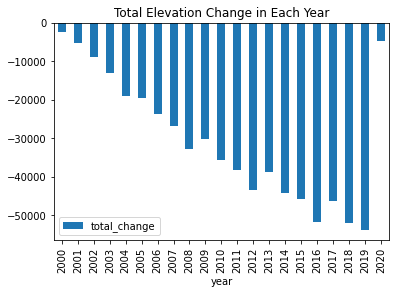

In [53]:
print("---- Iceland ----")
total_change_count = (iceland_df.withColumn('year', f.year('Time_formatted'))
                                           .groupBy('year').agg(f.sum('dh').alias('total_change'),
                                                                f.count('year').alias('total_rows')))

total_change_count.orderBy('year').show(n=21)

df_to_pd = (total_change_count.select('year', 'total_change')
                             .orderBy('year')
                             .toPandas())

df_to_pd.plot.bar(x='year', y='total_change', title='Total Elevation Change in Each Year')

---- Europe ----
+----+-------------------+----------+
|year|       total_change|total_rows|
+----+-------------------+----------+
|2000|-15884.197995130671|     51050|
|2001| -39051.07801257004|     43197|
|2002| -69174.50501979352|     47124|
|2003| -99484.08398807235|     47124|
|2004|  -142960.646999878|     51051|
|2005| -148225.7450104918|     43197|
|2006|-189366.55501894897|     47124|
|2007|  -217051.131975319|     47124|
|2008|-266910.57098235737|     51051|
|2009| -253489.8920897398|     43197|
|2010|  -304239.944086508|     47124|
|2011|-333365.05394044134|     47124|
|2012| -394447.9359792711|     51051|
|2013|-358964.33905955777|     43197|
|2014| -417897.6690465766|     47124|
|2015|-447174.54098961153|     47124|
|2016| -517441.8150885637|     51051|
|2017| -465776.4630795206|     43197|
|2018|   -537065.35995518|     47124|
|2019| -566134.6039925467|     47124|
|2020| -48481.10999443941|      3927|
+----+-------------------+----------+



<AxesSubplot:title={'center':'Total Elevation Change in Each Year'}, xlabel='year'>

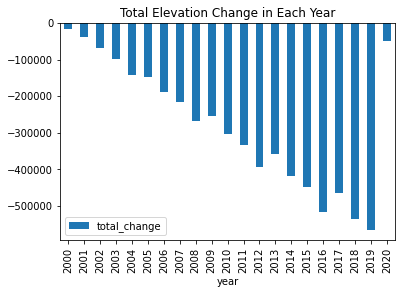

In [54]:
print("---- Europe ----")
total_change_count = (europe_df.withColumn('year', f.year('Time_formatted'))
                                           .groupBy('year').agg(f.sum('dh').alias('total_change'),
                                                                f.count('year').alias('total_rows')))

total_change_count.orderBy('year').show(n=21)

df_to_pd = (total_change_count.select('year', 'total_change')
                             .orderBy('year')
                             .toPandas())

df_to_pd.plot.bar(x='year', y='total_change', title='Total Elevation Change in Each Year')